<a href="https://colab.research.google.com/github/sizhky/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla Autoencoder on MNIST

In [1]:
# !pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
trn_ds = MNIST('~/datasets/MNIST/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('~/datasets/MNIST/content/', transform=img_transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/content/MNIST/raw/train-images-idx3-ubyte.gz to /home/guy/datasets/MNIST/content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/content/MNIST/raw/train-labels-idx1-ubyte.gz to /home/guy/datasets/MNIST/content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/content/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/guy/datasets/MNIST/content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/guy/datasets/MNIST/content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/guy/datasets/MNIST/content/MNIST/raw



In [4]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [6]:
# !pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [7]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000	trn_loss: 0.254	val_loss: 0.193	(8.80s - 35.20s remaining)
EPOCH: 2.000	trn_loss: 0.179	val_loss: 0.166	(17.64s - 26.46s remaining)
EPOCH: 3.000	trn_loss: 0.160	val_loss: 0.155	(26.47s - 17.65s remaining)
EPOCH: 4.000	trn_loss: 0.152	val_loss: 0.150	(35.30s - 8.83s remaining)
EPOCH: 5.000	trn_loss: 0.148	val_loss: 0.146	(44.28s - 0.00s remaining)


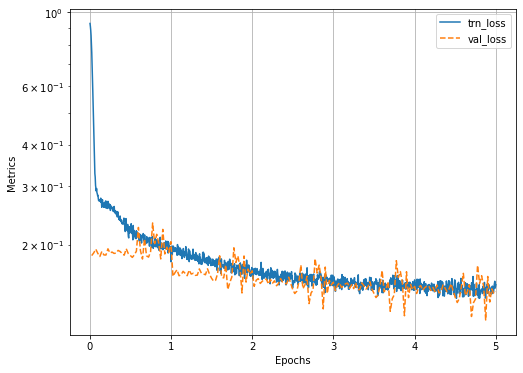

In [8]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

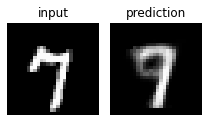

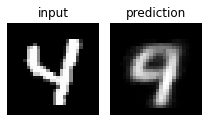

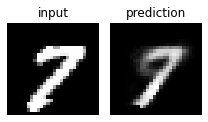

In [9]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

## Exploring the impact of latent dimensionality
lets repeat the experiment with different latent dimensionality.

EPOCH: 1.000	trn_loss: 0.238	val_loss: 0.134	(8.91s - 35.62s remaining)
EPOCH: 2.000	trn_loss: 0.112	val_loss: 0.094	(17.85s - 26.78s remaining)
EPOCH: 3.000	trn_loss: 0.089	val_loss: 0.081	(26.74s - 17.82s remaining)
EPOCH: 4.000	trn_loss: 0.078	val_loss: 0.072	(35.71s - 8.93s remaining)
EPOCH: 5.000	trn_loss: 0.070	val_loss: 0.065	(44.61s - 0.00s remaining)


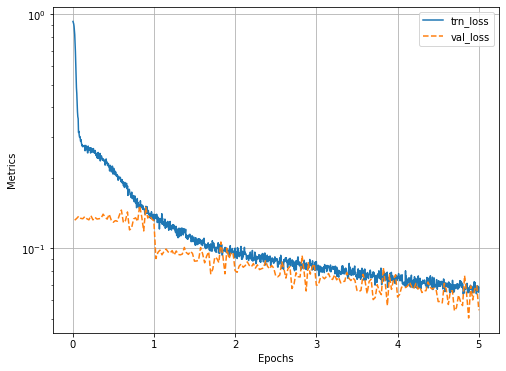

EPOCH: 1.000	trn_loss: 0.264	val_loss: 0.211	(8.87s - 35.47s remaining)
EPOCH: 2.000	trn_loss: 0.202	val_loss: 0.194	(17.77s - 26.65s remaining)
EPOCH: 3.000	trn_loss: 0.189	val_loss: 0.186	(26.66s - 17.77s remaining)
EPOCH: 4.000	trn_loss: 0.182	val_loss: 0.179	(35.55s - 8.89s remaining)
EPOCH: 5.000	trn_loss: 0.178	val_loss: 0.176	(44.48s - 0.00s remaining)


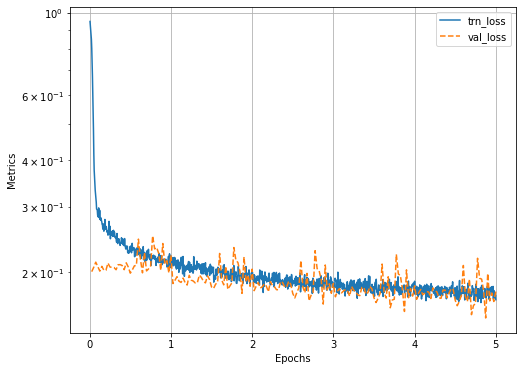

EPOCH: 1.000	trn_loss: 0.275	val_loss: 0.205	(8.90s - 35.61s remaining)
EPOCH: 2.000	trn_loss: 0.190	val_loss: 0.176	(17.87s - 26.80s remaining)
EPOCH: 3.000	trn_loss: 0.169	val_loss: 0.161	(26.80s - 17.86s remaining)
EPOCH: 4.000	trn_loss: 0.158	val_loss: 0.154	(35.74s - 8.93s remaining)
EPOCH: 5.000	trn_loss: 0.153	val_loss: 0.150	(44.69s - 0.00s remaining)


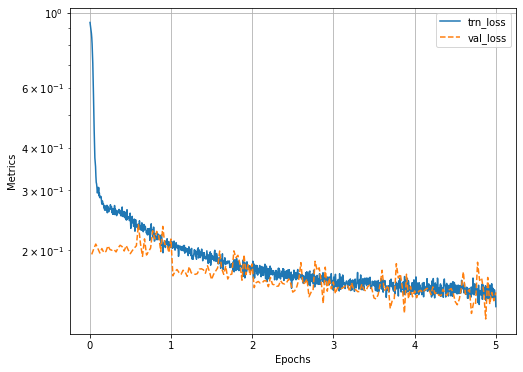

EPOCH: 1.000	trn_loss: 0.240	val_loss: 0.166	(8.99s - 35.96s remaining)
EPOCH: 2.000	trn_loss: 0.151	val_loss: 0.139	(17.95s - 26.93s remaining)
EPOCH: 3.000	trn_loss: 0.133	val_loss: 0.128	(26.87s - 17.92s remaining)
EPOCH: 4.000	trn_loss: 0.125	val_loss: 0.122	(35.81s - 8.95s remaining)
EPOCH: 5.000	trn_loss: 0.121	val_loss: 0.118	(44.82s - 0.00s remaining)


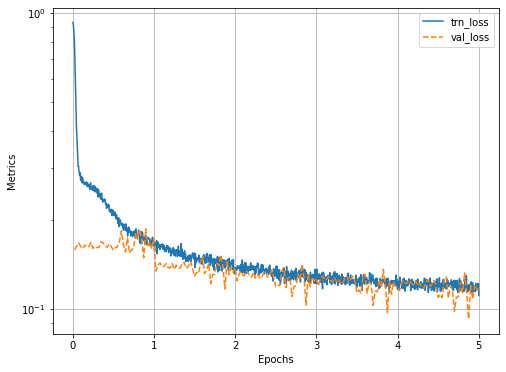

EPOCH: 1.000	trn_loss: 0.235	val_loss: 0.145	(9.07s - 36.28s remaining)
EPOCH: 2.000	trn_loss: 0.129	val_loss: 0.113	(18.13s - 27.19s remaining)
EPOCH: 3.000	trn_loss: 0.105	val_loss: 0.098	(27.18s - 18.12s remaining)
EPOCH: 4.000	trn_loss: 0.097	val_loss: 0.092	(36.29s - 9.07s remaining)
EPOCH: 5.000	trn_loss: 0.092	val_loss: 0.089	(45.34s - 0.00s remaining)


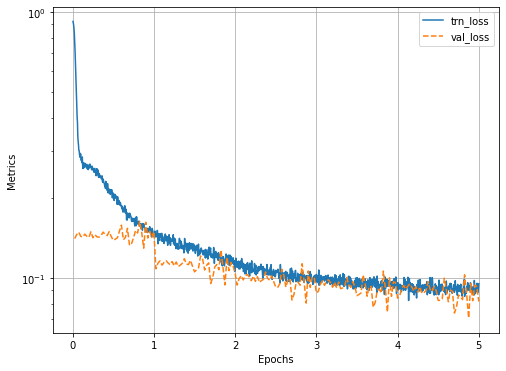

In [10]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

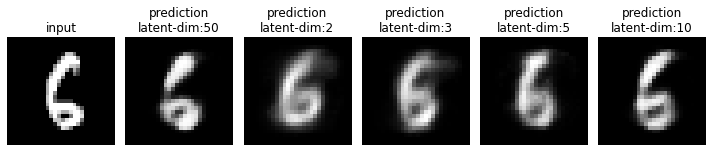

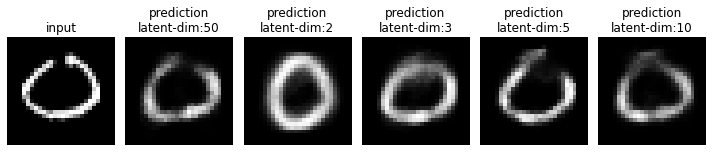

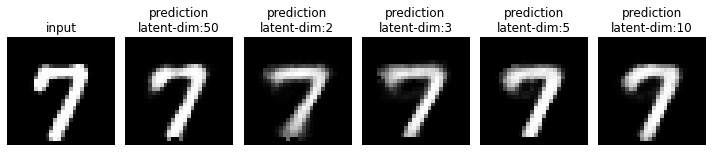

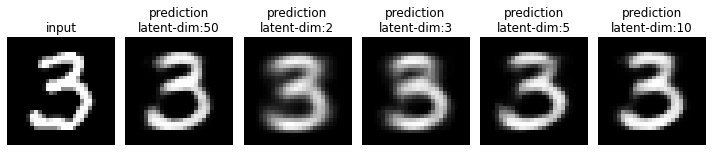

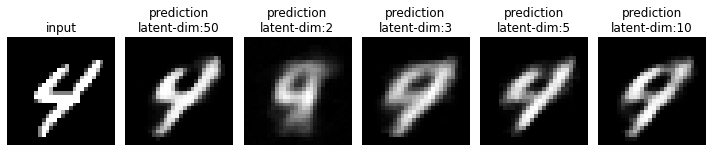

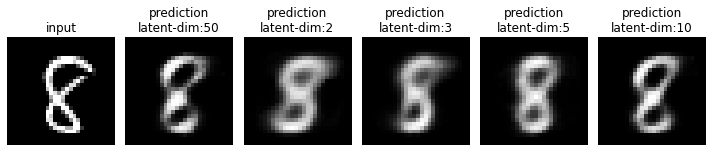

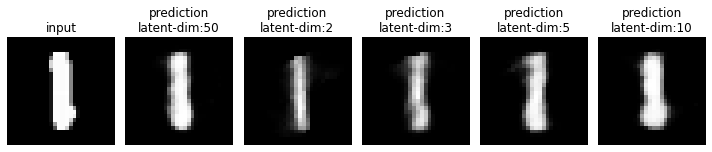

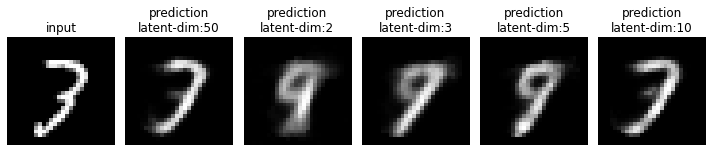

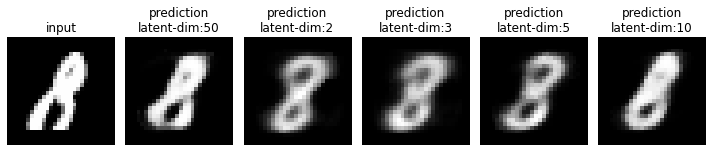

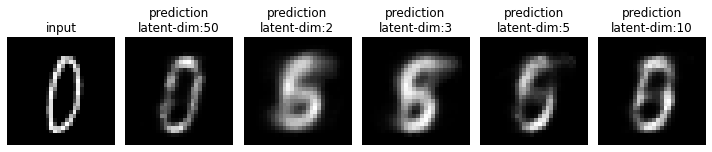

In [11]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()